<h1 style="font-size:300%">Inventory Management Kika Group Ltd.</h1>

In this notebook a forecasting model, that will predict future sales based on various aspects, will be built. The model will allow the company to:

1. Automatically predict when stock levels will run low for fast-selling products.
2. Optimize restocking schedules based on expected demand.
3. Reduce stockouts and prevent lost sales due to unavailability.
4. Minimize excess inventory for slow-moving products, reducing storage costs.

<img src="images\K-logo.png" width="150px" height="150px" alt="Kika Logo">

Kika Group Ltd. currently operates with [ERP.net](https://erp.net/), where they store all of their data since they started business. From stock inventory and sales to all of their customers, this application is very crucial for the company. An access to this application has been given to the developers of this model and gahtering data throughout all iterations is going to be done from there.

As a more B2B (business to business) oriented brand and being known in over 60 countries, the company faces many challenges, some of which are stockouts, lost sales due to unavailability, excessive inventory for slow-moving products and many more.

That is why with this model we will solve some of their problems regarding their stock management.

In [497]:
import sklearn
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


print("scikit-learn version:", sklearn.__version__)     # 1.6.1
print("pandas version:", pd.__version__)            # 2.2.3
print("seaborn version:", sns.__version__)          # 0.13.2

scikit-learn version: 1.6.1
pandas version: 2.1.4
seaborn version: 0.13.2


<h1 style="font-size:300%">Iteration 2 - Work</h1>

During Iteration 1, we made significant improvements across all areas of the project—from Exploratory Data Analysis (EDA) to Model Engineering. By correcting our dataset and properly analyzing trends and spikes, we uncovered the true potential of our AI model.

The main objective for this iteration is to build upon the progress made previously and take the next step toward delivering a reliable, product-level demand forecasting model.

To achieve this, we will follow a structured approach—starting from Data Provisioning and moving through each critical step, just as we did in the earlier iterations, to ensure accuracy and consistency in our results.

# 📦 Data Provisioning

Once again, we will begin by loading our previous sales dataset, which proved effective in the last iteration. To enhance our model and reach our current goals, we will introduce an additional dataset containing the stock levels of all products.

By combining these two datasets, we aim to generate more accurate and actionable demand forecasts.

In [498]:
sales_data = pd.read_csv("sales_strollers_01012023_01012025_new.csv", encoding="utf-8", delimiter=";")
sales_data.sample(5)

,Customer,Product Description,Document Date,Document Type,Document No,Product Group,Product,Quantity,Quantity Unit,Quantity Base,Unit Price,Line Amount,Document Currency,Line Amount In Base Currency,Sales Order,Sales Person,Customer Sales Person,Sales Person Group Name
4419,DIMIMA D.O.O,Pushchair Libro Beige 2023,20.7.2023,Invoice,3710057853,100103: Bebeshki letni kolichki,31001030143,5,pcs,5,40,200,EUR,"391,17",042:1710124105 - Porachka ot klient bez DDS,SEVIM ALIEVA MUSTAFOVA - PETROVA,SEVIM ALIEVA MUSTAFOVA - PETROVA,Външен пазар
7920,HIPOLEND AD,Pushchair Cloe Mint 2023,16.6.2023,Invoice,3710056711,100103: Bebeshki letni kolichki,31001030161,2,pcs,2,"129,46","258,92",BGN,"258,92",041:1710122940 - Porachka ot klient,SABIHA KOTALAK,SABIHA KOTALAK,Пловдив
16604,PEGAS GRUP 25 OOD,Pushchair Miley Dark Grey 2024,5.9.2024,Invoice,3710071675,100103: Bebeshki letni kolichki,31001030188,1,pcs,1,"130,35789","123,84",BGN,"123,84",041:1710156664 - Porachka ot klient,ZDRAVKO KIRILOV,SABIHA KOTALAK,Вътрешен пазар
19357,ShOURUM,Pushchair Miley Mint,28.1.2023,Stokovo-parichen otchet,1000009259,100103: Bebeshki letni kolichki,31001030134,1,pcs,1,"204,17","204,17",BGN,"204,17",043:3112438170 - Prodazhba ot magazin,KRASIMIRA PETROVA,KRASIMIRA PETROVA,Пловдив
17259,POULIS SOTIRIOS,Pushchair Beetle Dark Grey,8.2.2023,Invoice,3710052290,100103: Bebeshki letni kolichki,31001030076,2,pcs,2,"38,305","76,61",EUR,"149,84",042:1710111922 - Porachka ot klient bez DDS,ELENA GYULEVA,VASSILIS GIOTIS,Външен пазар


Now it is of most importance that we actually understand what is going on with the dataset. A step that we missed in the previous iteration so in this one, before we get to actual modelling we are going to first pay huge attention to every single column of the dataset.

In [499]:
print(sales_data.columns.to_list())

['Customer', 'Product Description', 'Document Date', 'Document Type', 'Document No', 'Product Group', 'Product', 'Quantity', 'Quantity Unit', 'Quantity Base', 'Unit Price', 'Line Amount', 'Document Currency', 'Line Amount In Base Currency', 'Sales Order', 'Sales Person', 'Customer Sales Person', 'Sales Person Group Name']


First off the immediate columns to drop are  *`Customer`*(for this iteration we do not need it, but we might use to for later iterations for market segmentation) *`Quantity Unit`*(because it is always pcs), *`Sales Order`*(internal order reference, which may be good for joining other systems, but at the moment we do not need it), *`Sales Person`*(other than analyzing salesperson performance for forecasting it is unnecessary), *`Customer Sales Person`*, *`Sales Person Group Name`*(which at the moment may not be supportive unless we forecast by region also), and maybe *`Document No`*. because it does not correlate to any of the products somehow and it would not be useful to keep it and misguide the model.

Also if **`"Quantity Unit"`** has only `"pcs"` as value we should also consider dropping it.

Finally another column we should pay attention is the `Document Type`, which we are going to analyze later on.

In [500]:
sales_data["Quantity Unit"].unique()

array(['pcs'], dtype=object)

As we can see `"pcs"` is the only value in that column and because it won't help us in any way we will include in the columns that we are going to drop.

In [501]:
sales_data.drop(columns=[
    'Customer',
    'Quantity Unit',
    'Sales Order',
    'Document No',
    'Sales Person',
    'Customer Sales Person',
    'Sales Person Group Name'
], inplace=True)

Now that we have dropped all the immediately noticeable unusefull columns, let's have a closer look into the `Document Type` column.

In [502]:
sales_data['Document Type'].unique()

array(['Invoice', 'Credit Note', 'Stokovo-parichen otchet',
       'Stokovo-parichen otchet za ES', 'Debit Note',
       'Stokovo-parichen otchet Onlayn magazin BG'], dtype=object)

Because I am going to drop the other rows other than the "Invoice" one and I do not want to translate the rows inside the dataset, I am going to translate every unique value and I am going to explain why we do not need them. Please note that all of the values were explained by the stakeholder and all of our actions are according to his assumptions.

1. *`Credit Note`* - A return or refund issued to a customer. Currently for this iteration it may be not smart to include customer returns, BUT if we have time for a more advanced model later, we can definetely explore incorporation.
2. *`"Stokovo-parichen otchet"`* or *`Stock-money report`* - this is a stock-money report our stakeholder makes and alone said we do not need it for the model.
3. *`Stokovo-parichen otchet za ES`* or *`Stock-money report for EU`* - same as above, but from all european sales
4. *`Stokovo-parichen otchet Onlayn magazin BG`* or *`Stock-money report for Online Webshop`* - same as above, but only from online shop

But before we drop them let's analyze the total rows we have in store and after we drop other rows (others different than `Invoices`) we will see if it indeed appropriate to drop them or not. 

In [503]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22251 entries, 0 to 22250
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Product Description           22251 non-null  object
 1   Document Date                 22251 non-null  object
 2   Document Type                 22251 non-null  object
 3   Product Group                 22251 non-null  object
 4   Product                       22251 non-null  int64 
 5   Quantity                      22251 non-null  int64 
 6   Quantity Base                 22251 non-null  int64 
 7   Unit Price                    22251 non-null  object
 8   Line Amount                   22251 non-null  object
 9   Document Currency             22251 non-null  object
 10  Line Amount In Base Currency  22251 non-null  object
dtypes: int64(3), object(8)
memory usage: 1.9+ MB


In [504]:
sales_data = sales_data[sales_data['Document Type'] == 'Invoice'].reset_index(drop=True)

In [505]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20602 entries, 0 to 20601
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Product Description           20602 non-null  object
 1   Document Date                 20602 non-null  object
 2   Document Type                 20602 non-null  object
 3   Product Group                 20602 non-null  object
 4   Product                       20602 non-null  int64 
 5   Quantity                      20602 non-null  int64 
 6   Quantity Base                 20602 non-null  int64 
 7   Unit Price                    20602 non-null  object
 8   Line Amount                   20602 non-null  object
 9   Document Currency             20602 non-null  object
 10  Line Amount In Base Currency  20602 non-null  object
dtypes: int64(3), object(8)
memory usage: 1.7+ MB


As we can see, removing all rows that are not labeled as "Invoices" reduced the dataset by exactly 1,649 entries, which represents approximately 7% of the total data. This indicates that have no problem continuing our work with this particular dataset. And now that we are left with only the invoices, we should not bother keeping this column and we can also drop it, as it does not bring any correlation as well.

In [506]:
sales_data.drop(columns=[
    'Document Type',
], inplace=True)

Now next columns to be analyzed and to see how they differ are the `Unit Price`, `Line Amount`, `Line Amount In Base Currency` and `Currency`. 
1. The unit price is the price per unit of the actual product. If the quantity is 1, then the unit price will be equal to the line amount or almost equivalent, because some invoices have discounts recorder (according to our stakeholder).
2. Line amount is the total revenue of the invoice that the sales employee registers (Unit Price x Quantity) in the currency mentioned in the next column.
3. Line Amount In Base Currency is the monetary value of the sale expressed in Kika's default currency — BGN in our case (Bulgarian Lev).

Note that even when Quantity = 1, we should rely on the Line Amount In Base Currency, because it is in BGN and its the currency that the company operates in.

The Unit Price becomes less reliable for modeling revenue or demand — it's more of a reference, not a guaranteed source of truth.


In [507]:
sales_data['Document Currency'].unique()  

array(['BGN', 'EUR', 'USD'], dtype=object)

Now we can see that there are invoices with different currencies, but as we mentioned earlier `Line Amount In Base Currency` comes to our help and we do not need to manually calculate the revenue in one currency, which is done in that column. So for all the reasons above we are going to remove the `Unit Price`, `Line Amount` and `Currency`, so that we are left with only one column regarding the revenue and that way we are not causing any confusions. Also from the initial table at the start we can see that the values are

In [508]:
sales_data.drop(columns=['Unit Price', 'Line Amount', 'Document Currency'], inplace=True)
sales_data.rename(columns={'Line Amount In Base Currency': 'Revenue in BGN'}, inplace=True)
sales_data.head(5)

,Product Description,Document Date,Product Group,Product,Quantity,Quantity Base,Revenue in BGN
0,Autofolding pushchair Joy Dark Grey,29.10.2024,100103: Bebeshki letni kolichki,31001030204,1,1,"152,33"
1,Pushchair Miley Dark Grey 2023,18.6.2024,100103: Bebeshki letni kolichki,31001030146,10,10,"1088,55"
2,Pushchair Miley Dark Grey 2023,26.3.2024,100103: Bebeshki letni kolichki,31001030146,3,3,"326,57"
3,Pushchair Miley Dark Grey 2023,18.6.2024,100103: Bebeshki letni kolichki,31001030146,4,4,"435,42"
4,Pushchair Miley Dark Grey 2023,23.4.2024,100103: Bebeshki letni kolichki,31001030146,10,10,"1088,55"


Now that we are coming close to our desired and well-cleaned dataset two more columns should be immediately studied and those are the `Quantity` and `Quantity Base`. From the first 5 rows it seems that there are the same, but let's actually check. 

In [509]:
difference = (sales_data['Quantity'] != sales_data['Quantity Base']).sum()
print(f"Rows where Quantity and Quantity Base differ: {difference}")


Rows where Quantity and Quantity Base differ: 0


The above result means we can safely drop one of them, and by convention, it’s cleaner to keep the standardized one — usually `Quantity Base`.

In [510]:
sales_data.drop(columns=[
    'Quantity',
], inplace=True)

In [511]:
sales_data.head(5)

,Product Description,Document Date,Product Group,Product,Quantity Base,Revenue in BGN
0,Autofolding pushchair Joy Dark Grey,29.10.2024,100103: Bebeshki letni kolichki,31001030204,1,"152,33"
1,Pushchair Miley Dark Grey 2023,18.6.2024,100103: Bebeshki letni kolichki,31001030146,10,"1088,55"
2,Pushchair Miley Dark Grey 2023,26.3.2024,100103: Bebeshki letni kolichki,31001030146,3,"326,57"
3,Pushchair Miley Dark Grey 2023,18.6.2024,100103: Bebeshki letni kolichki,31001030146,4,"435,42"
4,Pushchair Miley Dark Grey 2023,23.4.2024,100103: Bebeshki letni kolichki,31001030146,10,"1088,55"


Also the Product column should be renamed as it holds not the actual name of the product, but as the stakeholder explained it is their SKU (stock keeping unit) number, with which they track and store all of their products. One could also ask why do we need both the names and their SKU of the products and I would simply say that:

- SKU serves as the unique product identifier and is essential for all core operations, including merging datasets and making product-level predictions.

- Product Description is kept to improve readability and visualization, making it easier to interpret results during analysis. Additionally, it may prove useful for handling future tasks such as clustering, grouping, or enriching the data with external sources.

In [512]:
sales_data.rename(columns={'Product': 'SKU'}, inplace=True)
sales_data.head(5)

,Product Description,Document Date,Product Group,SKU,Quantity Base,Revenue in BGN
0,Autofolding pushchair Joy Dark Grey,29.10.2024,100103: Bebeshki letni kolichki,31001030204,1,"152,33"
1,Pushchair Miley Dark Grey 2023,18.6.2024,100103: Bebeshki letni kolichki,31001030146,10,"1088,55"
2,Pushchair Miley Dark Grey 2023,26.3.2024,100103: Bebeshki letni kolichki,31001030146,3,"326,57"
3,Pushchair Miley Dark Grey 2023,18.6.2024,100103: Bebeshki letni kolichki,31001030146,4,"435,42"
4,Pushchair Miley Dark Grey 2023,23.4.2024,100103: Bebeshki letni kolichki,31001030146,10,"1088,55"


Now that we have analyzed all the columns, excluded irrelevant ones and kept the others, we should now pay attention to their data types as for the model, this step is crucial.

In [513]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20602 entries, 0 to 20601
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Product Description  20602 non-null  object
 1   Document Date        20602 non-null  object
 2   Product Group        20602 non-null  object
 3   SKU                  20602 non-null  int64 
 4   Quantity Base        20602 non-null  int64 
 5   Revenue in BGN       20602 non-null  object
dtypes: int64(2), object(4)
memory usage: 965.8+ KB


As we can see there are 20602 rows, which is not that bad and even more good is that there are no empty values (there are no rows with some empty column values). 

First we have the Document Date we shoud convert it to `datetime` so we can sort by time, group by week/month/year, resample, plot trends and forecast properly.

The `Revenue in BGN` needs to be float with commas instead of dots.

The rest columns are their appropriate data type.

Let's now commence with the data cleaning and processing the data and first convert all the columns we said that they need to be converted.

In [514]:
sales_data['Document Date'] = pd.to_datetime(
    sales_data['Document Date'],
    format='%d.%m.%Y',     # day.month.year format
    errors='coerce'        # invalid formats become NaT
)

sales_data['Document Date'].head()

0   2024-10-29
1   2024-06-18
2   2024-03-26
3   2024-06-18
4   2024-04-23
Name: Document Date, dtype: datetime64[ns]

In [515]:
cols_to_clean = ['Revenue in BGN']

for col in cols_to_clean:
    sales_data[col] = sales_data[col].str.replace(',', '.', regex=False)
    sales_data[col] = sales_data[col].astype(float)

In [516]:
sales_data.dtypes

Product Description            object
Document Date          datetime64[ns]
Product Group                  object
SKU                             int64
Quantity Base                   int64
Revenue in BGN                float64
dtype: object

Perfect! We converted them successfully.

Now that we have converted **`date`** to an appropriate data type we should combine into, which would not only help us visualize trends, but also because during iteration 0 that sales data had individual rows for each sale transaction (per product, per date) and we used those individual transactions as rows, we added time-based features like *`month`*, *`week`*, *`day_of_week`*, BUT we did not group or structure the data per stroller model over time. 

In other words we missed the "time series per product" structure meaning, we did not actually aggregate daily sales per stroller. That led to the model treating each sale as an isolated event and not taking into consideration the same stroller sold over time. Therefore it couldn't learn product-specific trends, just general patterns across that dataset. 

That is why to avoid confusing the model we are going to create the `monthly_sales` DataFrame to transform detailed transaction-level data into a summarized time series format, where each row represents monthly sales per product (SKU).

That way we:
- Instead of working with thousands of individual invoices, we now have 1 row per SKU per month.
- Much easier for training a demand forecasting model.
- We can now add lag values, rolling averages, seasonal effects, and trend indicators.
- We get total units sold and total revenue for each product per month.

In [517]:
sales_data.sort_values('Document Date', inplace=True)
sales_data['Month'] = sales_data['Document Date'].dt.to_period('M').dt.to_timestamp()
sales_data.head(5)

,Product Description,Document Date,Product Group,SKU,Quantity Base,Revenue in BGN,Month
15182,Stroller 3in1 transf. seat Beloved Dark Grey,2023-01-04,100101: Kombinirani bebeshki kolichki 3 v 1,31001010118,1,285.14,2023-01-01
8010,Pushchair Juno Beige 2020,2023-01-04,100103: Bebeshki letni kolichki,31001030107,1,127.29,2023-01-01
2642,Stroller 2in1 with carrycot Thea Dark Grey,2023-01-04,100102: Kombinirani bebeshki kolichki 2 v 1,31001020110,1,541.59,2023-01-01
14751,Pushchair Beetle Beige,2023-01-04,100103: Bebeshki letni kolichki,31001030077,1,79.43,2023-01-01
425,Stroller 3in1 Madrid Mint Melange 2020,2023-01-04,100101: Kombinirani bebeshki kolichki 3 v 1,31001010135,1,416.07,2023-01-01


In [518]:
monthly_sales = (
    sales_data
    .groupby(['SKU', 'Product Description', 'Product Group', 'Month'])
    .agg(
        Quantity=('Quantity Base', 'sum'),
        Revenue=('Revenue in BGN', 'sum')
    )
    .reset_index()
)

monthly_sales.head(5)

,SKU,Product Description,Product Group,Month,Quantity,Revenue
0,31001010007,Stroller 3 in 1 Allure Lilac,100101: Kombinirani bebeshki kolichki 3 v 1,2024-12-01,2,623.88
1,31001010045,Stroller 3 in 1 Madrid Green Melange,100101: Kombinirani bebeshki kolichki 3 v 1,2024-12-01,1,250.00
2,31001010055,Stroller 3in1 transf. seat Darling Beige,100101: Kombinirani bebeshki kolichki 3 v 1,2023-01-01,3,683.96
3,31001010055,Stroller 3in1 transf. seat Darling Beige,100101: Kombinirani bebeshki kolichki 3 v 1,2023-02-01,2,435.88
4,31001010055,Stroller 3in1 transf. seat Darling Beige,100101: Kombinirani bebeshki kolichki 3 v 1,2024-12-01,1,201.36


This format is ideal when we want to predict future monthly demand per product.

Now that we applied all cleaning methods with the additional comments to the sales dataset we are left with our *NEW* dataset of the stock level of the products. Let's use the same cleaning methods to this dataset also.

In [519]:
stock_level = pd.read_csv("stock_level_strollers_01012025.csv", encoding="utf-8", delimiter=";")
stock_level.sample(5)

,Product Group Level 4,Product Name,Store,Product,Quantity,Quantity Unit,Quantity Base
1030,100102: Kombinirani bebeshki kolichki 2 v 1,Stroller 2 in 1 Beloved Dark Grey,1415 PLOVDIV KIKA GRUP - OKOLOVRASTEN PAT,31001020060,0,pcs,0
2407,100105: Obiknoveni bebeshki kolichki,Stand for carrycot & car seat UGO,1415 PLOVDIV KIKA GRUP - OKOLOVRASTEN PAT,31001050024,0,pcs,0
2314,100104: Bebeshki kolichki za bliznatsi,Kolichka za bliznatsi Torro Duo Black,1406 PLOVDIV KIKA GRUP,31001040001,0,pcs,0
1134,100102: Kombinirani bebeshki kolichki 2 v 1,Stroller 2 in 1 Tender Flowers,1410 PLOVDIV KIKA GRUP TRUD,31001020042,1,pcs,1
421,100101: Kombinirani bebeshki kolichki 3 v 1,Stroller 3in1 Claude Grey,1414 PLOVDIV KIKA GRUP TRANZITEN,31001010162,0,pcs,0


In [520]:
print(stock_level.columns.to_list())

['Product Group Level 4', 'Product Name', 'Store', 'Product', 'Quantity', 'Quantity Unit', 'Quantity Base']


Now immedietely we can cut off the columns `Store`, because we're doing national-level forecasting (not per store), so individual store locations aren't needed. If we later want per-store predictions, we can add it back.

Then of course before we cut it let's check if only *`pcs`* is the value in `Quantity Unit`. If it is we are also going to cut it.

In [521]:
stock_level['Quantity Unit'].unique()

array(['pcs'], dtype=object)

As we can see it so we are also going to add it to the 'to be' dropped columns.

Now let's check if there is any different values in `Quantity` and `Quantity Base`.

In [522]:
difference = (stock_level['Quantity'] != stock_level['Quantity Base']).sum()
print(f"Rows where Quantity and Quantity Base differ: {difference}")


Rows where Quantity and Quantity Base differ: 0


The above result means we can safely drop one of them, and by convention, it’s cleaner to keep the standardized one — usually `Quantity Base`, which are going to rename to `Current Stock`.

In [523]:
stock_level = stock_level.drop(columns=[
    'Store',           
    'Quantity',       
    'Quantity Unit'
])

stock_level.head()

,Product Group Level 4,Product Name,Product,Quantity Base
0,100101: Kombinirani bebeshki kolichki 3 v 1,Baby Stroller Allure Blue,31001010008,0
1,100101: Kombinirani bebeshki kolichki 3 v 1,Baby Stroller Allure Blue,31001010008,0
2,100101: Kombinirani bebeshki kolichki 3 v 1,Baby Stroller Allure Blue,31001010008,0
3,100101: Kombinirani bebeshki kolichki 3 v 1,Baby Stroller Allure Blue,31001010008,1
4,100101: Kombinirani bebeshki kolichki 3 v 1,Baby Stroller Allure Blue,31001010008,0


In [524]:
stock_level.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2541 entries, 0 to 2540
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Product Group Level 4  2541 non-null   object
 1   Product Name           2541 non-null   object
 2   Product                2541 non-null   int64 
 3   Quantity Base          2541 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 79.5+ KB


Also after we do a check-up on the data types with *`.info()`* everything seems perfect. No missing values and also all of the columns' values are in the correct `Dtype`. This confirmation allows us now to begin with merging. Let's just also rename the `Product` column to `SKU` for more clarity and also the previously mentioned column `Quantity Base`.

In [525]:
stock_level.rename(columns={'Product': 'SKU', 'Quantity Base': 'Current_Stock'}, inplace=True)
stock_level.head(5)

,Product Group Level 4,Product Name,SKU,Current_Stock
0,100101: Kombinirani bebeshki kolichki 3 v 1,Baby Stroller Allure Blue,31001010008,0
1,100101: Kombinirani bebeshki kolichki 3 v 1,Baby Stroller Allure Blue,31001010008,0
2,100101: Kombinirani bebeshki kolichki 3 v 1,Baby Stroller Allure Blue,31001010008,0
3,100101: Kombinirani bebeshki kolichki 3 v 1,Baby Stroller Allure Blue,31001010008,1
4,100101: Kombinirani bebeshki kolichki 3 v 1,Baby Stroller Allure Blue,31001010008,0


Perfect! Now we are officially ready for merging our datasets.

In [526]:
stock_by_sku = stock_level.groupby('SKU', as_index=False)['Current_Stock'].sum()
merged_df = monthly_sales.merge(stock_by_sku, on='SKU', how='left')
merged_df['Current_Stock'] = merged_df['Current_Stock'].fillna(0).astype(int) #fill the current stock of products who do not have any stock with 0
merged_df.head()

,SKU,Product Description,Product Group,Month,Quantity,Revenue,Current_Stock
0,31001010007,Stroller 3 in 1 Allure Lilac,100101: Kombinirani bebeshki kolichki 3 v 1,2024-12-01,2,623.88,0
1,31001010045,Stroller 3 in 1 Madrid Green Melange,100101: Kombinirani bebeshki kolichki 3 v 1,2024-12-01,1,250.00,5
2,31001010055,Stroller 3in1 transf. seat Darling Beige,100101: Kombinirani bebeshki kolichki 3 v 1,2023-01-01,3,683.96,9
3,31001010055,Stroller 3in1 transf. seat Darling Beige,100101: Kombinirani bebeshki kolichki 3 v 1,2023-02-01,2,435.88,9
4,31001010055,Stroller 3in1 transf. seat Darling Beige,100101: Kombinirani bebeshki kolichki 3 v 1,2024-12-01,1,201.36,9


Now to check if everything about our 'to be worked with' dataset is alright, we are going to check some columns in case during the merging any errors occured.

In [527]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2647 entries, 0 to 2646
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   SKU                  2647 non-null   int64         
 1   Product Description  2647 non-null   object        
 2   Product Group        2647 non-null   object        
 3   Month                2647 non-null   datetime64[ns]
 4   Quantity             2647 non-null   int64         
 5   Revenue              2647 non-null   float64       
 6   Current_Stock        2647 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(2)
memory usage: 144.9+ KB


In [528]:
merged_df['Current_Stock'].isna().sum()


0

In [529]:
print("Negative stock values:", (merged_df['Current_Stock'] < 0).sum())
print("Max stock:", merged_df['Current_Stock'].max())

Negative stock values: 0
Max stock: 2339


In [530]:
merged_df[merged_df['Current_Stock'] == 0].head(99999)

,SKU,Product Description,Product Group,Month,Quantity,Revenue,Current_Stock
0,31001010007,Stroller 3 in 1 Allure Lilac,100101: Kombinirani bebeshki kolichki 3 v 1,2024-12-01,2,623.88,0
29,31001010058,Stroller 3 in 1 Darling Green,100101: Kombinirani bebeshki kolichki 3 v 1,2023-01-01,1,237.50,0
49,31001010063,Stroller 3in1 with carrycot Ava Army Green,100101: Kombinirani bebeshki kolichki 3 v 1,2024-07-01,26,9511.35,0
50,31001010063,Stroller 3in1 with carrycot Ava Army Green,100101: Kombinirani bebeshki kolichki 3 v 1,2024-08-01,2,705.04,0
51,31001010063,Stroller 3in1 with carrycot Ava Army Green,100101: Kombinirani bebeshki kolichki 3 v 1,2024-11-01,26,9332.50,0
...,...,...,...,...,...,...,...
2608,31001060014,Isofix base for car seat Amani,100106: Adaptori za bebeshka kolichka,2023-02-01,2,350.89,0
2609,31001060014,Isofix base for car seat Amani,100106: Adaptori za bebeshka kolichka,2023-03-01,7,1148.17,0
2610,31001060014,Isofix base for car seat Amani,100106: Adaptori za bebeshka kolichka,2023-11-01,4,462.76,0
2611,31001060016,Adaptor for stroller Joy,100106: Adaptori za bebeshka kolichka,2024-11-01,570,0.00,0


With those checks we can confirm that:
- We verified that no NaN values appeared after the merge, confirming a clean match.
- We also validated that there are no negative values, and the max stock quantity looked realistic (2339 units).
- That out of 2647 rows there are 288 with 0 stock, which potentially are stopped products or products that have sold out quickly. We will analyze this moving forward with our visualizations.

Before we get to the visualizations our consultant pointed out an interesting thing to further investigate. If we take a closer look into SKUs the 2nd to 6th digits of the SKU (positions 2–6) appear to match the numeric part of the Product Group code. Let's see if it is true. First since `SKU` is an *int* we first need to convert it to *str* safely and then slice it.

In [531]:
merged_df['SKU_str'] = merged_df['SKU'].astype(str).str.zfill(11) 
merged_df['Extracted_Group_Code'] = merged_df['SKU_str'].str[1:7]


In [532]:
merged_df.head(5)

,SKU,Product Description,Product Group,Month,Quantity,Revenue,Current_Stock,SKU_str,Extracted_Group_Code
0,31001010007,Stroller 3 in 1 Allure Lilac,100101: Kombinirani bebeshki kolichki 3 v 1,2024-12-01,2,623.88,0,31001010007,100101
1,31001010045,Stroller 3 in 1 Madrid Green Melange,100101: Kombinirani bebeshki kolichki 3 v 1,2024-12-01,1,250.00,5,31001010045,100101
2,31001010055,Stroller 3in1 transf. seat Darling Beige,100101: Kombinirani bebeshki kolichki 3 v 1,2023-01-01,3,683.96,9,31001010055,100101
3,31001010055,Stroller 3in1 transf. seat Darling Beige,100101: Kombinirani bebeshki kolichki 3 v 1,2023-02-01,2,435.88,9,31001010055,100101
4,31001010055,Stroller 3in1 transf. seat Darling Beige,100101: Kombinirani bebeshki kolichki 3 v 1,2024-12-01,1,201.36,9,31001010055,100101


Let's now extract the numeric group code from the actual `Product Group` column and then we will see if they match.

In [533]:
merged_df['Group_Code_from_Label'] = merged_df['Product Group'].str.extract(r'(\d{6})')

In [534]:
(merged_df['Extracted_Group_Code'] == merged_df['Group_Code_from_Label']).value_counts()

True    2647
Name: count, dtype: int64

In [535]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2647 entries, 0 to 2646
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   SKU                    2647 non-null   int64         
 1   Product Description    2647 non-null   object        
 2   Product Group          2647 non-null   object        
 3   Month                  2647 non-null   datetime64[ns]
 4   Quantity               2647 non-null   int64         
 5   Revenue                2647 non-null   float64       
 6   Current_Stock          2647 non-null   int64         
 7   SKU_str                2647 non-null   object        
 8   Extracted_Group_Code   2647 non-null   object        
 9   Group_Code_from_Label  2647 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(5)
memory usage: 206.9+ KB


In [536]:
merged_df.head(5)

,SKU,Product Description,Product Group,Month,Quantity,Revenue,Current_Stock,SKU_str,Extracted_Group_Code,Group_Code_from_Label
0,31001010007,Stroller 3 in 1 Allure Lilac,100101: Kombinirani bebeshki kolichki 3 v 1,2024-12-01,2,623.88,0,31001010007,100101,100101
1,31001010045,Stroller 3 in 1 Madrid Green Melange,100101: Kombinirani bebeshki kolichki 3 v 1,2024-12-01,1,250.00,5,31001010045,100101,100101
2,31001010055,Stroller 3in1 transf. seat Darling Beige,100101: Kombinirani bebeshki kolichki 3 v 1,2023-01-01,3,683.96,9,31001010055,100101,100101
3,31001010055,Stroller 3in1 transf. seat Darling Beige,100101: Kombinirani bebeshki kolichki 3 v 1,2023-02-01,2,435.88,9,31001010055,100101,100101
4,31001010055,Stroller 3in1 transf. seat Darling Beige,100101: Kombinirani bebeshki kolichki 3 v 1,2024-12-01,1,201.36,9,31001010055,100101,100101


As we can see it is exactly true. In all of the rows, which are 2647, the columns `Extracted_Group_Code` and `Group_Code_from_Label` are exactly the same. We can potentially after some evaluations with visualizations use the `Extracted_Group_Code` as a categorical feature, which can help group similar products together, help the model generailze better across related SKUs and act as a fallback if product names/descriptions are missing or noisy.

And now that we have confirmed our consultant's assumptions we can drop the temporary columns we used for validation. 

In [537]:
merged_df = merged_df.drop(columns=['SKU_str', 'Group_Code_from_Label'])

And since we extracted the code into a separate column we can remove the code part from the Product Group column altogether for redundancy and cleaner approach. And also keep the product group label/name for readiability during our visualizations.

In [538]:
merged_df['Product Group Label'] = merged_df['Product Group'].str.split(':', n=1).str[1].str.strip()
merged_df = merged_df.drop(columns=['Product Group'])
merged_df.head(5)

,SKU,Product Description,Month,Quantity,Revenue,Current_Stock,Extracted_Group_Code,Product Group Label
0,31001010007,Stroller 3 in 1 Allure Lilac,2024-12-01,2,623.88,0,100101,Kombinirani bebeshki kolichki 3 v 1
1,31001010045,Stroller 3 in 1 Madrid Green Melange,2024-12-01,1,250.00,5,100101,Kombinirani bebeshki kolichki 3 v 1
2,31001010055,Stroller 3in1 transf. seat Darling Beige,2023-01-01,3,683.96,9,100101,Kombinirani bebeshki kolichki 3 v 1
3,31001010055,Stroller 3in1 transf. seat Darling Beige,2023-02-01,2,435.88,9,100101,Kombinirani bebeshki kolichki 3 v 1
4,31001010055,Stroller 3in1 transf. seat Darling Beige,2024-12-01,1,201.36,9,100101,Kombinirani bebeshki kolichki 3 v 1


## 📈 Visualizing the data 

For a starting point I think we can use a chart to compare *Total Quantity Sold vs. Revenue per Month*. That way we can evaluate certain patterns we see, trends, whether some months show high quantity, but low quantity (same the other way around). Most importanly, becuase this is sales data I think that this graph would definitely open doors to deeper analysis.

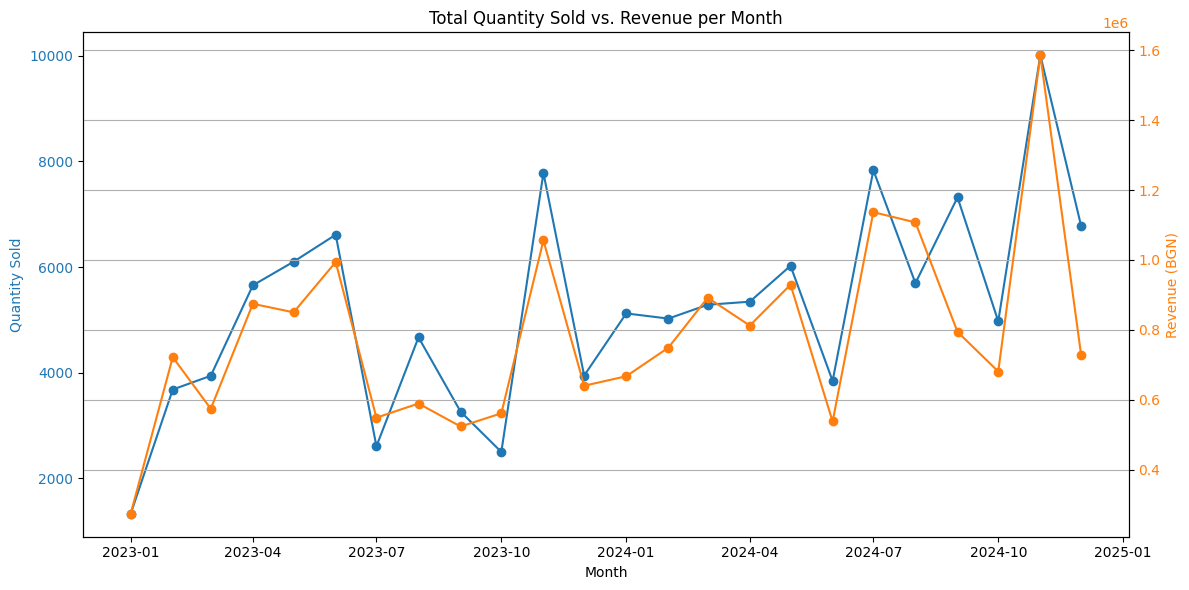

In [539]:
monthly_summary = (
    merged_df
    .groupby('Month')
    .agg({
        'Quantity': 'sum',
        'Revenue': 'sum'  #
    })
    .reset_index()
)

fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel('Month')
ax1.set_ylabel('Quantity Sold', color=color)
ax1.plot(monthly_summary['Month'], monthly_summary['Quantity'], marker='o', color=color, label='Total Quantity Sold')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Revenue (BGN)', color=color)
ax2.plot(monthly_summary['Month'], monthly_summary['Revenue'], marker='o', color=color, label='Total Revenue')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Total Quantity Sold vs. Revenue per Month')
fig.tight_layout()
plt.grid(True)
plt.show()


### Total Quantity Sold vs. Revenue per Month:
It is immediate that most months show a positive correlation between units sold and revenue, which in other words means that when quantity goes up, revenue also goes up. Another thing we clearly see is that every November there is a huge spike in total quantities sold and revenue. According to our stakeholder from the interview when asked about this he commented that, because it due to the wolrd wide known promotion "Black Friday" and also because of December holidays and presents, which babies also receive.

Of course there are some months, which underperform others like September and January. And again according to our stakeholder he said that these are their lowest demand months and out of all months these particilarly two always underperform. "That is why they set our goals for those months lower"- stakeholder added.

As I said we can dive deeper to analyze certain patterns we see and to do that we should see acutlaly what products/categories drive success and also products which struggle during key periods.

Let's now get to know our products even more and see which are the best-sellers during November.

November is one of the strongest months in terms of both units sold and total revenue. According to stakeholder input, this is largely driven by Black Friday promotions and holiday-related purchases. The goal here is to identify the top-performing products during this period.

/var/folders/41/d8pgsd4j1wg6_mvq030drk_00000gp/T/ipykernel_19305/2785458721.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


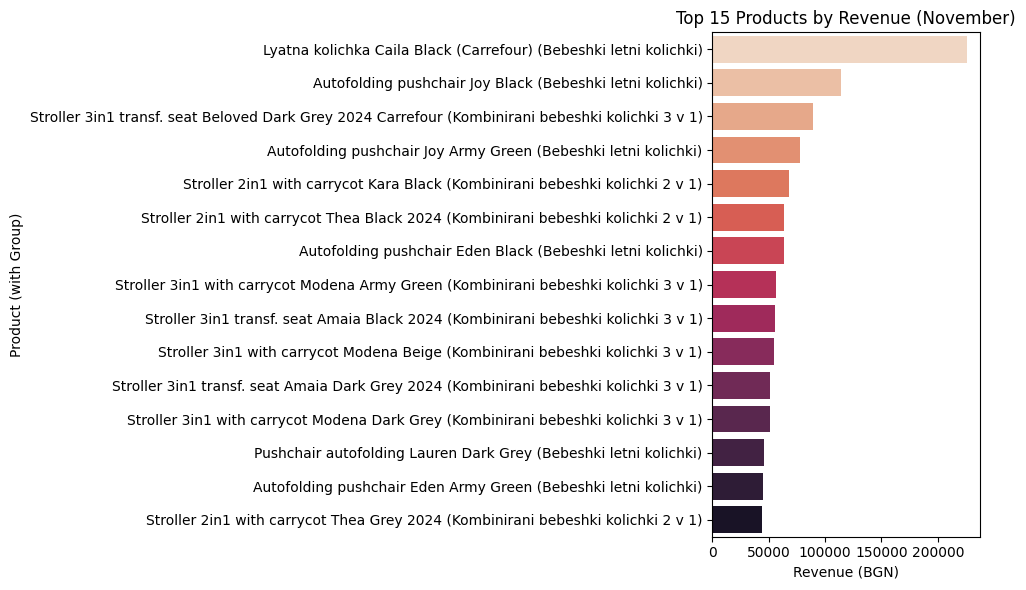

In [540]:
november_sales = merged_df[merged_df['Month'].dt.month == 11]

top_november_products = (
    november_sales
    .groupby(['SKU', 'Product Description', 'Product Group Label'])[['Quantity', 'Revenue']]
    .sum()
    .sort_values(by='Revenue', ascending=False)
    .head(15)
    .reset_index()
)

top_november_products['Label'] = (
    top_november_products['Product Description'] + 
    ' (' + top_november_products['Product Group Label'] + ')'
)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_november_products.sort_values(by='Revenue'),
    y='Label',
    x='Revenue',
    palette='rocket'
)
plt.title('Top 15 Products by Revenue (November)')
plt.xlabel('Revenue (BGN)')
plt.ylabel('Product (with Group)')
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()


/var/folders/41/d8pgsd4j1wg6_mvq030drk_00000gp/T/ipykernel_19305/2433421485.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


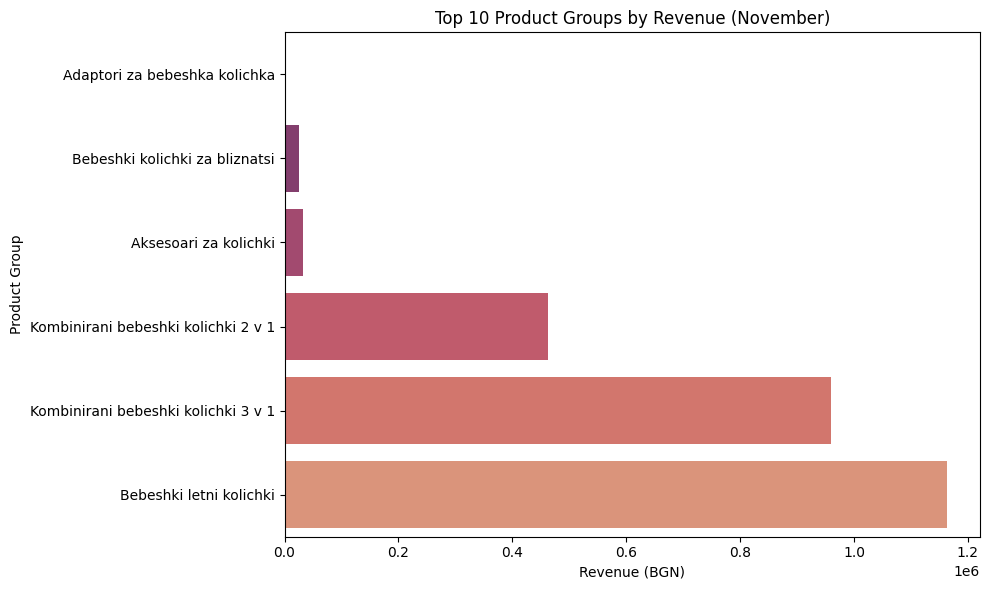

In [541]:
top_november_groups = (
    november_sales
    .groupby('Product Group Label')['Revenue']
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .reset_index()
)
plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_november_groups,
    y='Product Group Label',
    x='Revenue',
    palette='flare'
)
plt.title('Top 10 Product Groups by Revenue (November)')
plt.xlabel('Revenue (BGN)')
plt.ylabel('Product Group')
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()
